In [1]:
import pandas as pd
import numpy as np
import multiprocessing
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import gc
from time import time
import datetime
from tqdm import tqdm_notebook
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
warnings.simplefilter('ignore')
sns.set()
%matplotlib inline



In [2]:
train_transaction = pd.read_csv('C:/Users/Asus/Desktop/Data science/ieee-fraud-detection/train_transaction.csv'  )
test_transaction = pd.read_csv('C:/Users/Asus/Desktop/Data science/ieee-fraud-detection/test_transaction.csv'  )
train_identity= pd.read_csv('C:/Users/Asus/Desktop/Data science/ieee-fraud-detection/train_identity.csv'  )
test_identity = pd.read_csv('C:/Users/Asus/Desktop/Data science/ieee-fraud-detection/test_identity.csv'  )

In [3]:
train_transaction.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


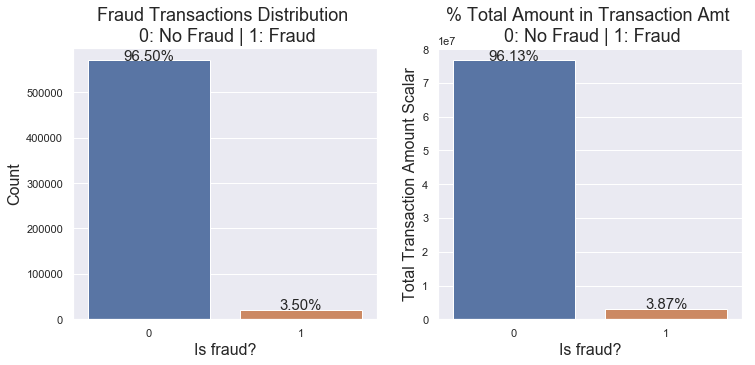

In [4]:
train_transaction['TransactionAmt'] = train_transaction['TransactionAmt'].astype(float) #  besh nconverty Strings l Floats
total = len(train_transaction)
total_amt = train_transaction.groupby(['isFraud'])['TransactionAmt'].sum().sum()
plt.figure(figsize=(12,5))

plt.subplot(121)
plot_tr = sns.countplot(x='isFraud', data=train_transaction)
plot_tr.set_title("Fraud Transactions Distribution \n 0: No Fraud | 1: Fraud", fontsize=18)
plot_tr.set_xlabel("Is fraud?", fontsize=16)
plot_tr.set_ylabel('Count', fontsize=16)
for p in plot_tr.patches:
    height = p.get_height()
    plot_tr.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=15) 
    
percent_amt = (train_transaction.groupby(['isFraud'])['TransactionAmt'].sum())
percent_amt = percent_amt.reset_index()
plt.subplot(122)
plot_tr_2 = sns.barplot(x='isFraud', y='TransactionAmt',  dodge=True, data=percent_amt)
plot_tr_2.set_title("% Total Amount in Transaction Amt \n 0: No Fraud | 1: Fraud", fontsize=18)
plot_tr_2.set_xlabel("Is fraud?", fontsize=16)
plot_tr_2.set_ylabel('Total Transaction Amount Scalar', fontsize=16)
for p in plot_tr_2.patches:
    height = p.get_height()
    plot_tr_2.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total_amt * 100),
            ha="center", fontsize=15) 

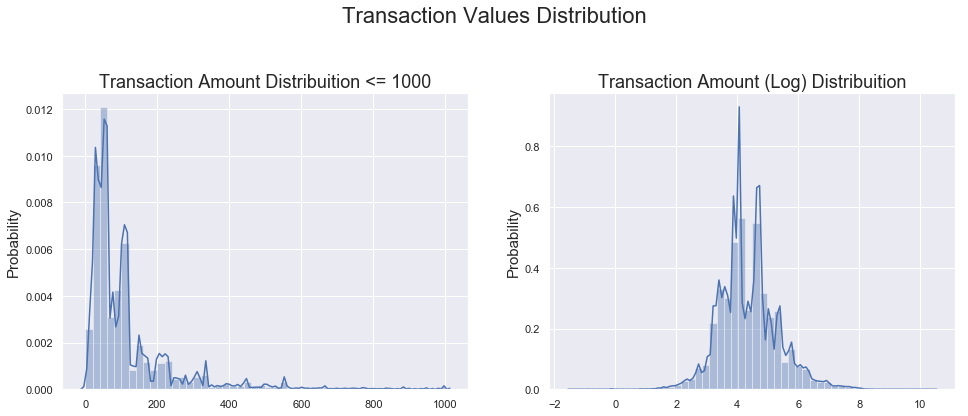

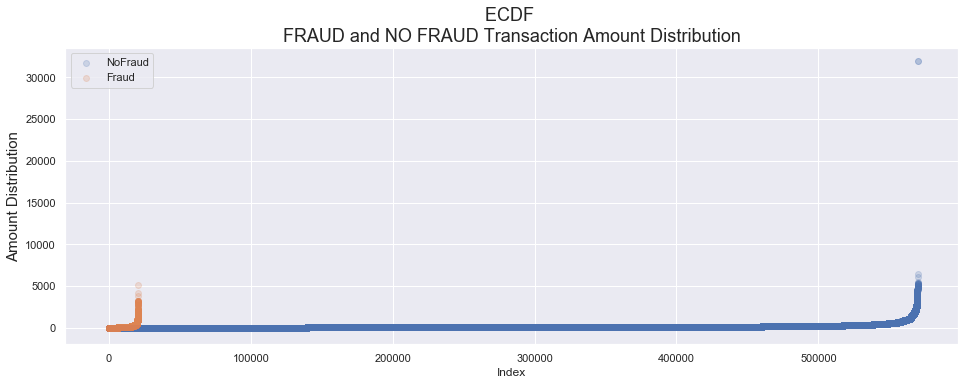

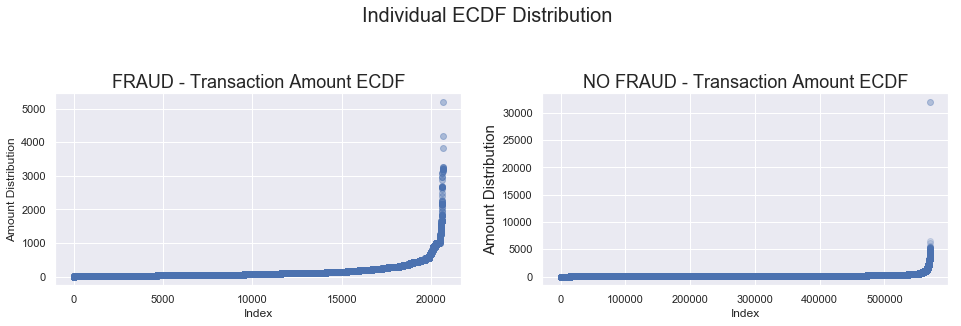

In [5]:
plt.figure(figsize=(16,12))
plt.suptitle('Transaction Values Distribution', fontsize=22)
plt.subplot(221)
sub_plot_1 = sns.distplot(train_transaction[train_transaction['TransactionAmt'] <= 1000]['TransactionAmt'])
sub_plot_1.set_title("Transaction Amount Distribuition <= 1000", fontsize=18)
sub_plot_1.set_xlabel("")
sub_plot_1.set_ylabel("Probability", fontsize=15)

plt.subplot(222)
sub_plot_2 = sns.distplot(np.log(train_transaction['TransactionAmt']))
sub_plot_2.set_title("Transaction Amount (Log) Distribuition", fontsize=18)
sub_plot_2.set_xlabel("")
sub_plot_2.set_ylabel("Probability", fontsize=15)

plt.figure(figsize=(16,12))


plt.subplot(212)
sub_plot_3 = plt.scatter(range(train_transaction[train_transaction['isFraud'] == 0].shape[0]),
                 np.sort(train_transaction[train_transaction['isFraud'] == 0]['TransactionAmt'].values), 
                 label='NoFraud', alpha=.2)
sub_plot_3 = plt.scatter(range(train_transaction[train_transaction['isFraud'] == 1].shape[0]),
                 np.sort(train_transaction[train_transaction['isFraud'] == 1]['TransactionAmt'].values), 
                 label='Fraud', alpha=.2)
sub_plot_3= plt.title("ECDF \nFRAUD and NO FRAUD Transaction Amount Distribution", fontsize=18)
sub_plot_3 = plt.xlabel("Index")
sub_plot_3 = plt.ylabel("Amount Distribution", fontsize=15)
sub_plot_3 = plt.legend()

plt.figure(figsize=(16,12))

plt.subplot(321)
sub_plot_4 = plt.scatter(range(train_transaction[train_transaction['isFraud'] == 1].shape[0]), 
                 np.sort(train_transaction[train_transaction['isFraud'] == 1]['TransactionAmt'].values), 
                label='isFraud', alpha=.4)
plt.title("FRAUD - Transaction Amount ECDF", fontsize=18)
plt.xlabel("Index")
plt.ylabel("Amount Distribution", fontsize=12)

plt.subplot(322)
sub_plot_5 = plt.scatter(range(train_transaction[train_transaction['isFraud'] == 0].shape[0]),
                 np.sort(train_transaction[train_transaction['isFraud'] == 0]['TransactionAmt'].values), 
                 label='NoFraud', alpha=.2)
sub_plot_5 = plt.title("NO FRAUD - Transaction Amount ECDF", fontsize=18)
sub_plot_5 = plt.xlabel("Index")
sub_plot_5 = plt.ylabel("Amount Distribution", fontsize=15)

plt.suptitle('Individual ECDF Distribution', fontsize=20)

plt.show()


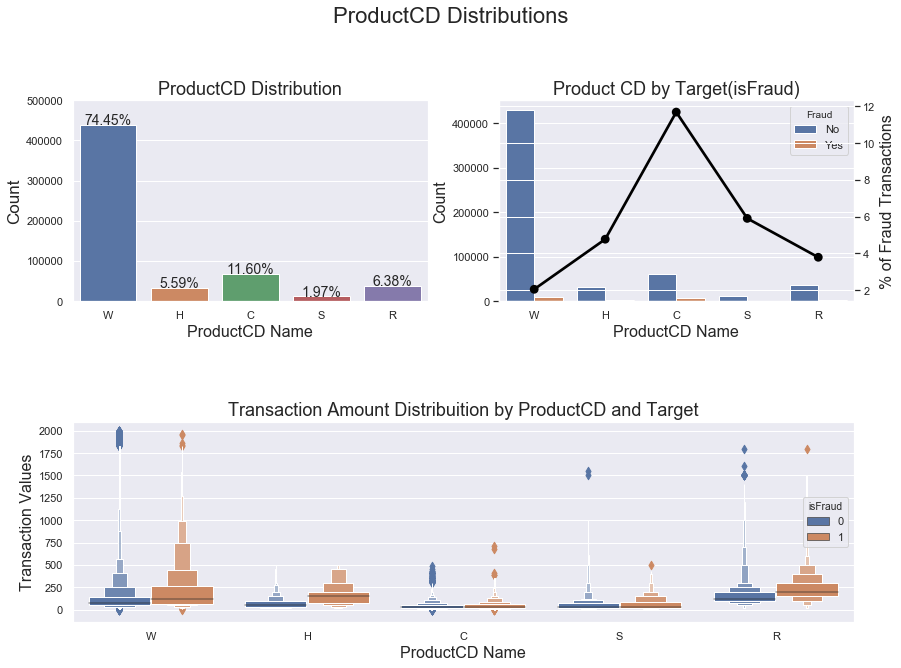

In [30]:
tmp = pd.crosstab(train_transaction['ProductCD'], train_transaction['isFraud'], normalize='index') * 100
tmp = tmp.reset_index()
tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

plt.figure(figsize=(14,10))
plt.suptitle('ProductCD Distributions', fontsize=22)

plt.subplot(221)
plot_1 = sns.countplot(x='ProductCD', data=train_transaction)

plot_1.set_title("ProductCD Distribution", fontsize=18)
plot_1.set_xlabel("ProductCD Name", fontsize=16)
plot_1.set_ylabel("Count", fontsize=17)
plot_1.set_ylim(0,500000)
for p in plot_1.patches:
    height = p.get_height()
    plot_1.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=14) 

plt.subplot(222)
plot_2 = sns.countplot(x='ProductCD', hue='isFraud', data=train_transaction)
plt.legend(title='Fraud', loc='best', labels=['No', 'Yes'])
plot_2_2 = plot_2.twinx()
plot_2_2 = sns.pointplot(x='ProductCD', y='Fraud', data=tmp, color='black', order=['W', 'H',"C", "S", "R"], legend=False)
# star hedha mtaaa akal courbe 
plot_2_2.set_ylabel("% of Fraud Transactions", fontsize=16)

plot_2.set_title("Product CD by Target(isFraud)", fontsize=18)
plot_2.set_xlabel("ProductCD Name", fontsize=16)
plot_2.set_ylabel("Count", fontsize=16)

plt.subplot(212)
plot_3 = sns.boxenplot(x='ProductCD', y='TransactionAmt', hue='isFraud', 
              data=train_transaction[train_transaction['TransactionAmt'] <= 2000] )
plot_3.set_title("Transaction Amount Distribuition by ProductCD and Target", fontsize=18)
plot_3.set_xlabel("ProductCD Name", fontsize=16)
plot_3.set_ylabel("Transaction Values", fontsize=16)

plt.subplots_adjust(hspace = 0.6, top = 0.85)

plt.show()

In [7]:
train_transaction.loc[train_transaction.card3.isin(train_transaction.card3.value_counts()[train_transaction.card3.value_counts() < 200].index), 'card3'] = "Others"
train_transaction.loc[train_transaction.card5.isin(train_transaction.card5.value_counts()[train_transaction.card5.value_counts() < 300].index), 'card5'] = "Others"

# ce bout de code à empecher l label mtaa x besh yodkhel baaadhouu 

### Visualizing Card 1, Card 2 , Card 3 and card 5 Distributions

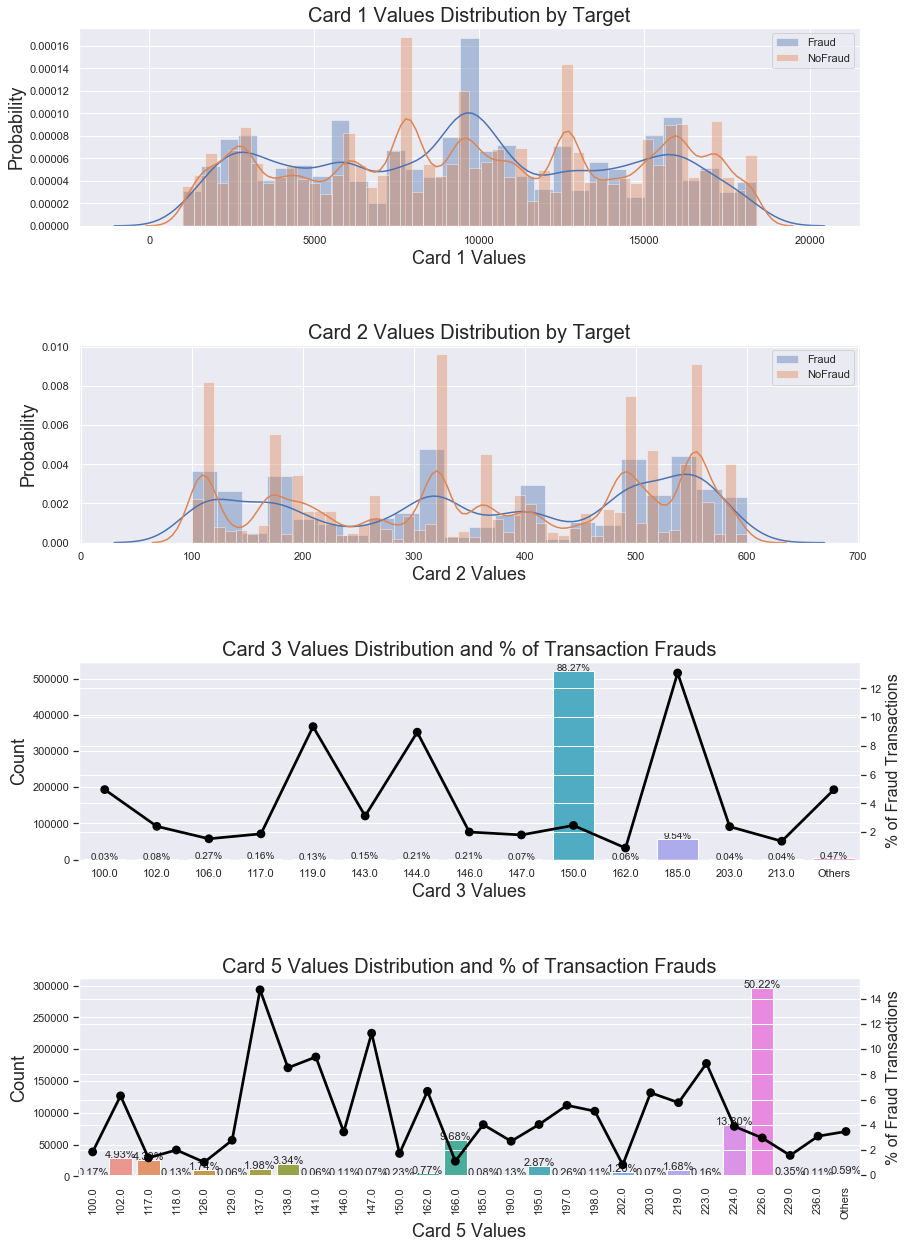

In [8]:
tmp = pd.crosstab(train_transaction['card3'], train_transaction['isFraud'], normalize='index') * 100
tmp = tmp.reset_index()
tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

tmp2 = pd.crosstab(train_transaction['card5'], train_transaction['isFraud'], normalize='index') * 100
tmp2 = tmp2.reset_index()
tmp2.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

plt.figure(figsize=(14,22))

plt.subplot(411)
plot_1 = sns.distplot(train_transaction[train_transaction['isFraud'] == 1]['card1'], label='Fraud')
plot_1 = sns.distplot(train_transaction[train_transaction['isFraud'] == 0]['card1'], label='NoFraud')
plot_1.legend()
plot_1.set_title("Card 1 Values Distribution by Target", fontsize=20)
plot_1.set_xlabel("Card 1 Values", fontsize=18)
plot_1.set_ylabel("Probability", fontsize=18)

plt.subplot(412)
plot_2 = sns.distplot(train_transaction[train_transaction['isFraud'] == 1]['card2'].dropna(), label='Fraud')
plot_2 = sns.distplot(train_transaction[train_transaction['isFraud'] == 0]['card2'].dropna(), label='NoFraud')
plot_2.legend()
plot_2.set_title("Card 2 Values Distribution by Target", fontsize=20)
plot_2.set_xlabel("Card 2 Values", fontsize=18)
plot_2.set_ylabel("Probability", fontsize=18)

plt.subplot(413)
plot_3 = sns.countplot(x='card3', data=train_transaction, order=list(tmp.card3.values))
plot_3_2 = plot_3.twinx()
plot_3_2 = sns.pointplot(x='card3', y='Fraud', data=tmp, 
                    color='black', order=list(tmp.card3.values))
plot_3_2.set_ylabel("% of Fraud Transactions", fontsize=16)
plot_3.set_title("Card 3 Values Distribution and % of Transaction Frauds", fontsize=20)
plot_3.set_xlabel("Card 3 Values", fontsize=18)
plot_3.set_ylabel("Count", fontsize=18)
for p in plot_3.patches:
    height = p.get_height()
    plot_3.text(p.get_x()+p.get_width()/2.,
            height + 25,
            '{:1.2f}%'.format(height/total*100),
            ha="center") 

plt.subplot(414)
plot_4 = sns.countplot(x='card5', data=train_transaction, order=list(tmp2.card5.values))
plot_4_2 = plot_4.twinx()
plot_4_2 = sns.pointplot(x='card5', y='Fraud', data=tmp2, 
                    color='black', order=list(tmp2.card5.values))
plot_4_2.set_ylabel("% of Fraud Transactions", fontsize=16)
plot_4.set_title("Card 5 Values Distribution and % of Transaction Frauds", fontsize=20)
plot_4.set_xticklabels(plot_4.get_xticklabels(),rotation=90)
plot_4.set_xlabel("Card 5 Values", fontsize=18)
plot_4.set_ylabel("Count", fontsize=18)
for p in plot_4.patches:
    height = p.get_height()
    plot_4.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center",fontsize=11) 
    
plt.subplots_adjust(hspace = 0.6, top = 0.85)


plt.show()

### Card 4 - Categorical Feature

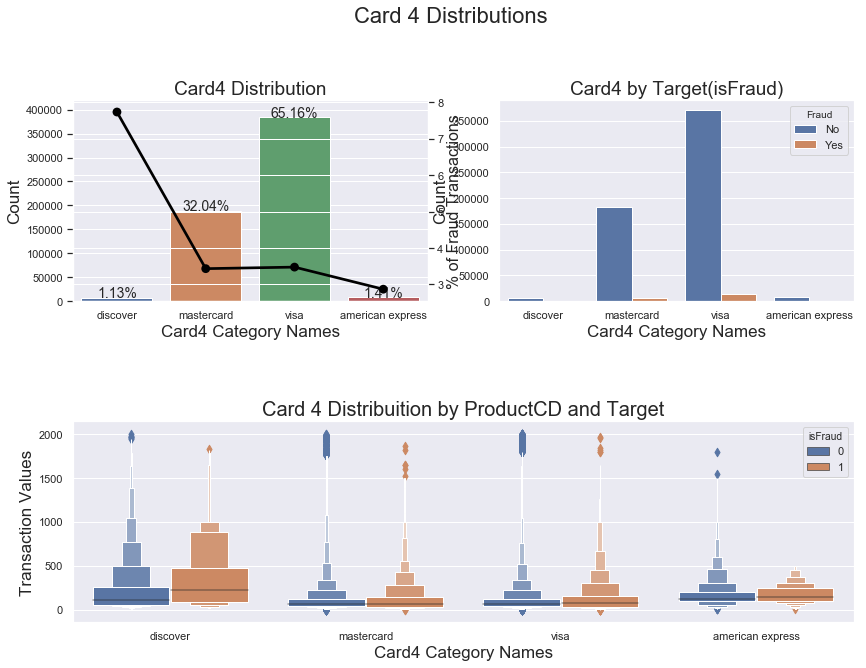

In [9]:
tmp = pd.crosstab(train_transaction['card4'], train_transaction['isFraud'], normalize='index') * 100
tmp = tmp.reset_index()
tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

plt.figure(figsize=(14,10))
plt.suptitle('Card 4 Distributions', fontsize=22)

plt.subplot(221)
plot_1 = sns.countplot(x='card4', data=train_transaction)


plot_1.set_title("Card4 Distribution", fontsize=19)
plot_1.set_ylim(0,420000)
plot_1.set_xlabel("Card4 Category Names", fontsize=17)
plot_1.set_ylabel("Count", fontsize=17)
for p in plot_1.patches:
    height = p.get_height()
    plot_1.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center",fontsize=14) 


plt.subplot(222)
plot_2 = sns.countplot(x='card4', hue='isFraud', data=train_transaction)
plt.legend(title='Fraud', loc='best', labels=['No', 'Yes'])
plot_2_2 = plot_1.twinx()
plot_2_2 = sns.pointplot(x='card4', y='Fraud', data=tmp, 
                   color='black', legend=False, 
                   order=['discover', 'mastercard', 'visa', 'american express'])
plot_2_2.set_ylabel("% of Fraud Transactions", fontsize=16)
plot_2.set_title("Card4 by Target(isFraud)", fontsize=19)
plot_2.set_xlabel("Card4 Category Names", fontsize=17)
plot_2.set_ylabel("Count", fontsize=17)

plt.subplot(212)
plot_3 = sns.boxenplot(x='card4', y='TransactionAmt', hue='isFraud', 
              data=train_transaction[train_transaction['TransactionAmt'] <= 2000] )
plot_3.set_title("Card 4 Distribuition by ProductCD and Target", fontsize=20)
plot_3.set_xlabel("Card4 Category Names", fontsize=17)
plot_3.set_ylabel("Transaction Values", fontsize=17)

plt.subplots_adjust(hspace = 0.6, top = 0.85)

plt.show()

### Card 6 - Categorical

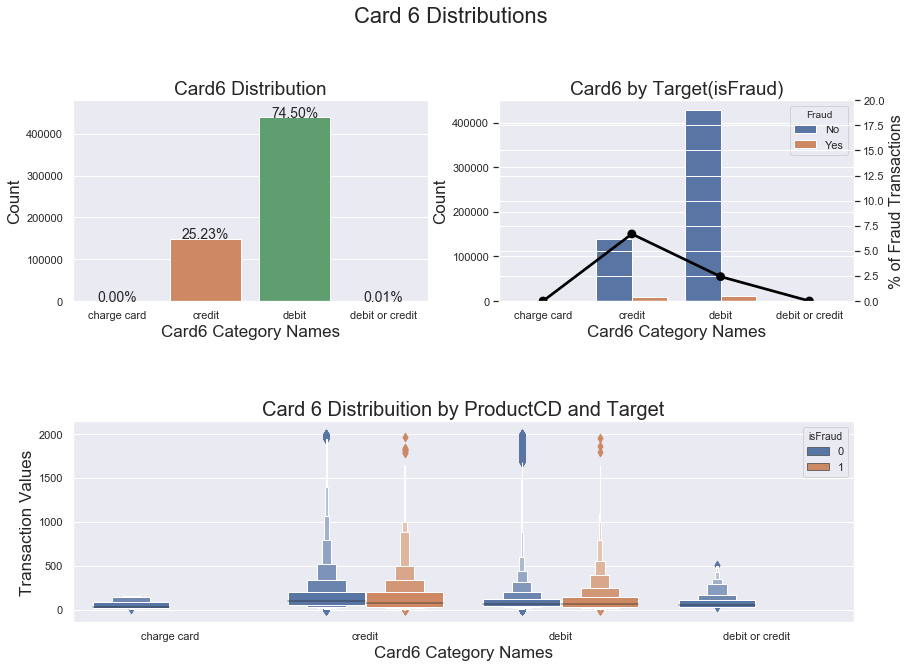

In [10]:
tmp = pd.crosstab(train_transaction['card6'], train_transaction['isFraud'], normalize='index') * 100
tmp = tmp.reset_index()
tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

plt.figure(figsize=(14,10))
plt.suptitle('Card 6 Distributions', fontsize=22)

plt.subplot(221)
plot_1 = sns.countplot(x='card6', data=train_transaction, order=list(tmp.card6.values))

plot_1.set_title("Card6 Distribution", fontsize=19)
plot_1.set_ylim(0,480000)
plot_1.set_xlabel("Card6 Category Names", fontsize=17)
plot_1.set_ylabel("Count", fontsize=17)
for p in plot_1.patches:
    height = p.get_height()
    plot_1.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center",fontsize=14) 

plt.subplot(222)
plot_2 = sns.countplot(x='card6', hue='isFraud', data=train_transaction, order=list(tmp.card6.values))
plt.legend(title='Fraud', loc='best', labels=['No', 'Yes'])
plot_2_2 = plot_2.twinx()
plot_2_2 = sns.pointplot(x='card6', y='Fraud', data=tmp, order=list(tmp.card6.values),
                   color='black', legend=False, )
plot_2_2.set_ylim(0,20)
plot_2_2.set_ylabel("% of Fraud Transactions", fontsize=16)
plot_2.set_title("Card6 by Target(isFraud)", fontsize=19)
plot_2.set_xlabel("Card6 Category Names", fontsize=17)
plot_2.set_ylabel("Count", fontsize=17)

plt.subplot(212)
plot_3 = sns.boxenplot(x='card6', y='TransactionAmt', hue='isFraud', order=list(tmp.card6.values),
              data=train_transaction[train_transaction['TransactionAmt'] <= 2000] )
plot_3.set_title("Card 6 Distribuition by ProductCD and Target", fontsize=20)
plot_3.set_xlabel("Card6 Category Names", fontsize=17)
plot_3.set_ylabel("Transaction Values", fontsize=17)

plt.subplots_adjust(hspace = 0.6, top = 0.85)

plt.show()

###  Exploring M1-M9 Features

In [11]:
for columns in ['M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9']:
    train_transaction[columns] = train_transaction[columns].fillna("Miss")
    
def ploting_dist_ratio(DataFile, Column, lim=2000):
    tmp = pd.crosstab(DataFile[Column], DataFile['isFraud'], normalize='index') * 100
    tmp = tmp.reset_index()
    tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

    plt.figure(figsize=(20,5))
    plt.suptitle(f'{Column} Distributions ', fontsize=22)

    plt.subplot(121)
    plot_1 = sns.countplot(x=Column, data=DataFile, order=list(tmp[Column].values))

    plot_1.set_title(f"{Column} Distribution\nCound and %Fraud by each category", fontsize=18)
    plot_1.set_ylim(0,400000)
    plot_1_2 = plot_1.twinx()
    plot_1_2 = sns.pointplot(x=Column, y='Fraud', data=tmp, order=list(tmp[Column].values),
                       color='black', legend=False, )
    plot_1_2.set_ylim(0,20)
    plot_1_2.set_ylabel("% of Fraud Transactions", fontsize=16)
    plot_1.set_xlabel(f"{Column} Category Names", fontsize=16)
    plot_1.set_ylabel("Count", fontsize=17)
    for p in plot_1_2.patches:
        height = p.get_height()
        plot_1_2.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(height/total*100),
                ha="center",fontsize=14) 
        
    perc_amt = (train_transaction.groupby(['isFraud',Column])['TransactionAmt'].sum() / total_amt * 100).unstack('isFraud')
    perc_amt = perc_amt.reset_index()
    perc_amt.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

    plt.subplot(122)
    plot_2 = sns.boxplot(x=Column, y='TransactionAmt', hue='isFraud', 
                     data=DataFile[DataFile['TransactionAmt'] <= lim], order=list(tmp[Column].values))
    plot_2_2 = plot_2.twinx()
    plot_2_2 = sns.pointplot(x=Column, y='Fraud', data=perc_amt, order=list(tmp[Column].values),
                       color='black', legend=False, )
    plot_2_2.set_ylim(0,5)
    plot_2_2.set_ylabel("%Fraud Total Amount", fontsize=16)
    plot_2.set_title(f"{Column} by Transactions dist", fontsize=18)
    plot_2.set_xlabel(f"{Column} Category Names", fontsize=16)
    plot_2.set_ylabel("Transaction Amount(U$)", fontsize=16)
        
    plt.subplots_adjust(hspace=.4, wspace = 0.35, top = 0.80)
    
    plt.show()

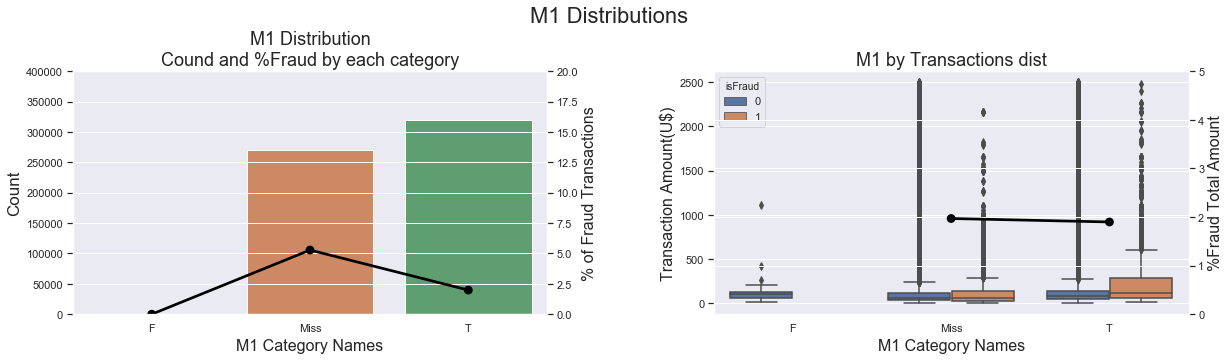

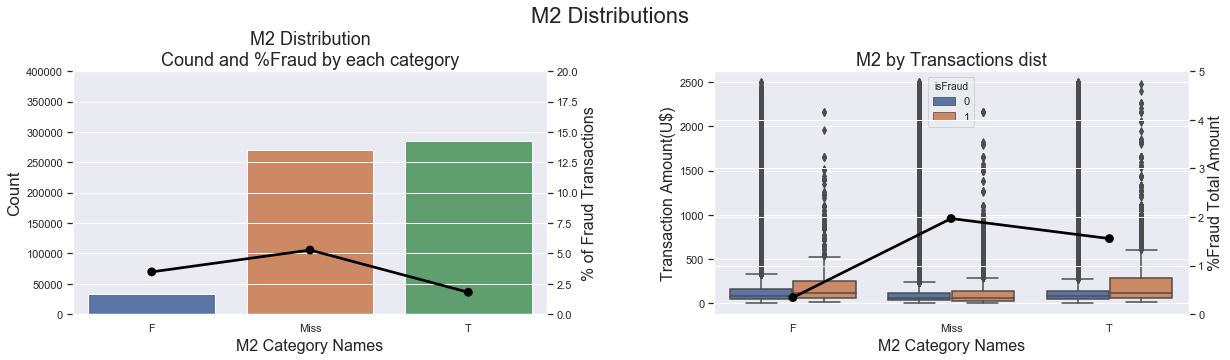

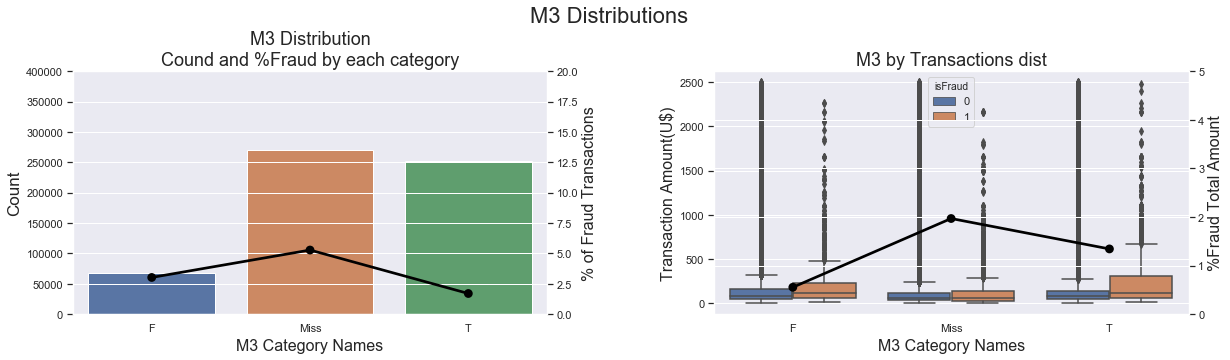

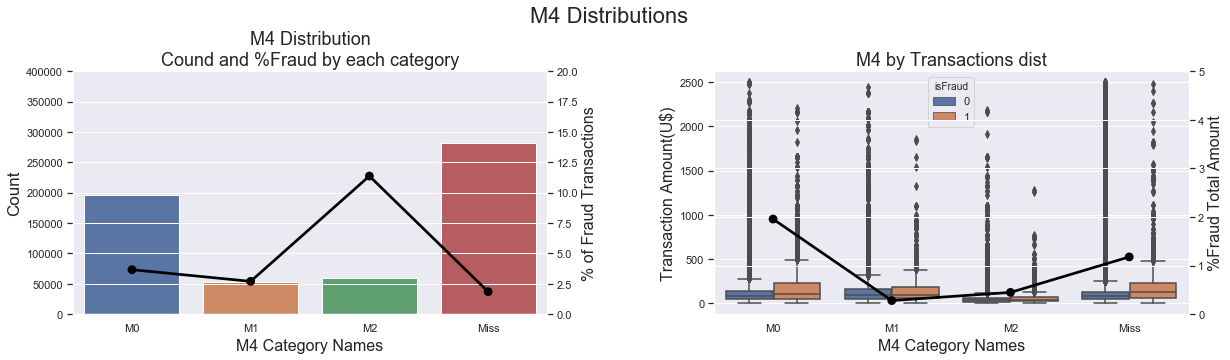

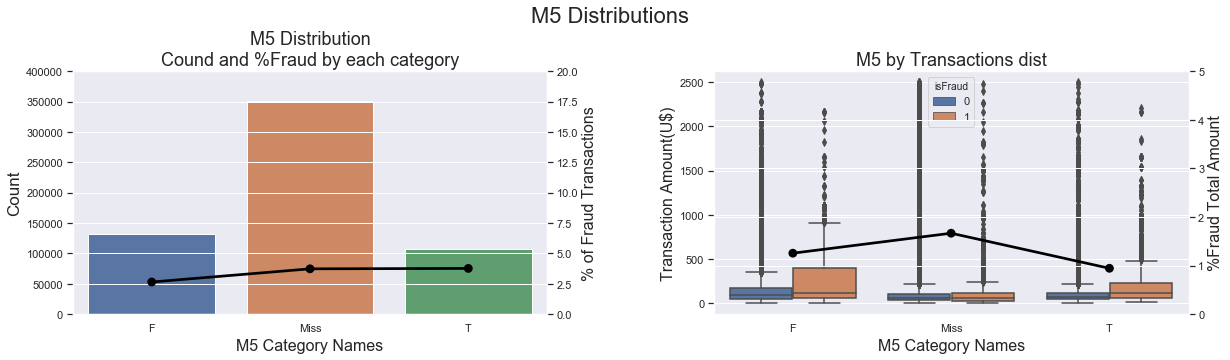

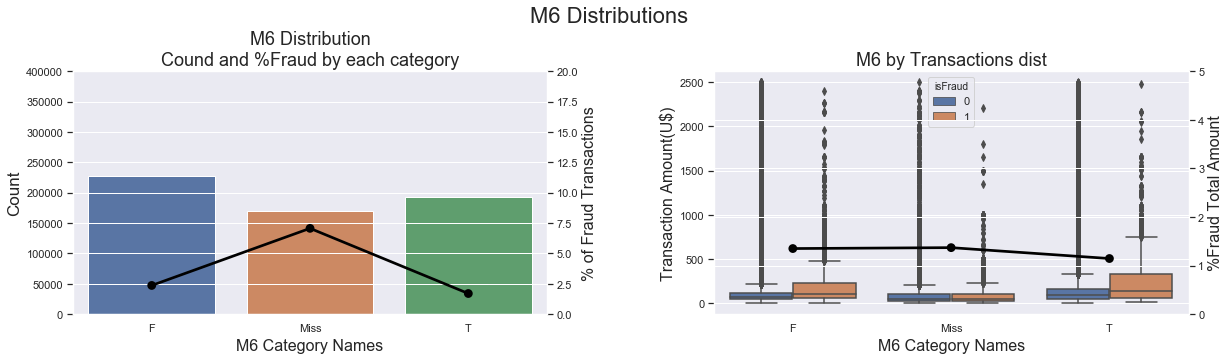

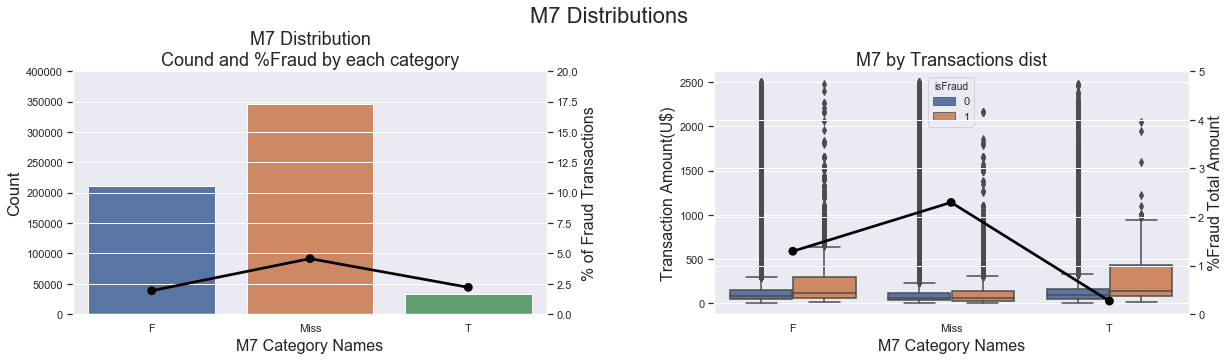

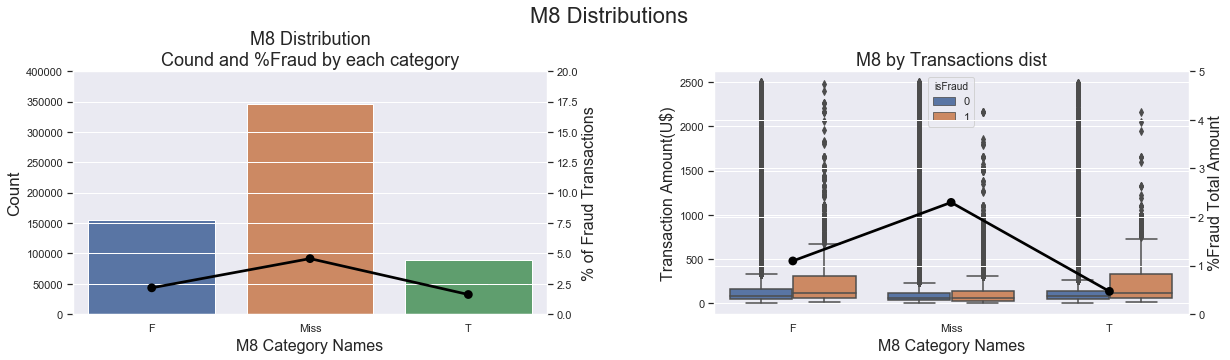

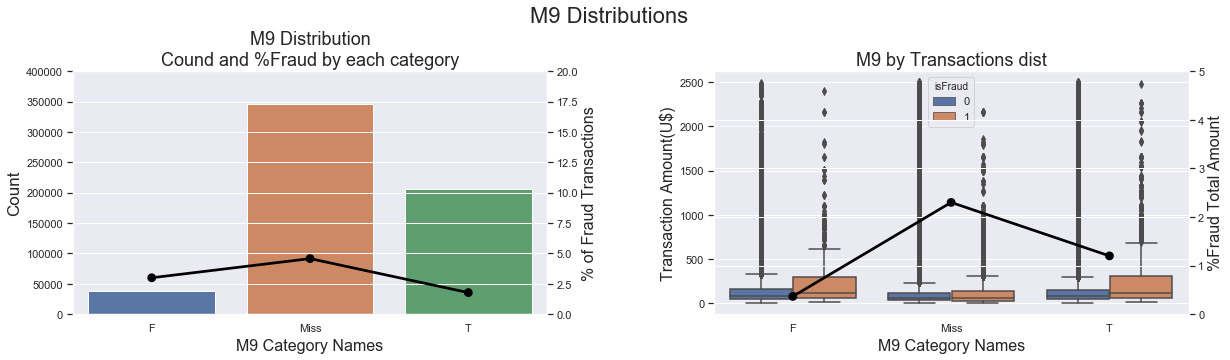

In [12]:
for columns in ['M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9']:
    ploting_dist_ratio(train_transaction, columns, lim=2500)

### Addr1 Distributions


In [16]:
train_transaction.loc[train_transaction.addr1.isin(train_transaction.addr1.value_counts()[train_transaction.addr1.value_counts() <= 5000 ].index), 'addr1'] = "Others"
train_transaction.loc[train_transaction.addr2.isin(train_transaction.addr2.value_counts()[train_transaction.addr2.value_counts() <= 50 ].index), 'addr2'] = "Others"

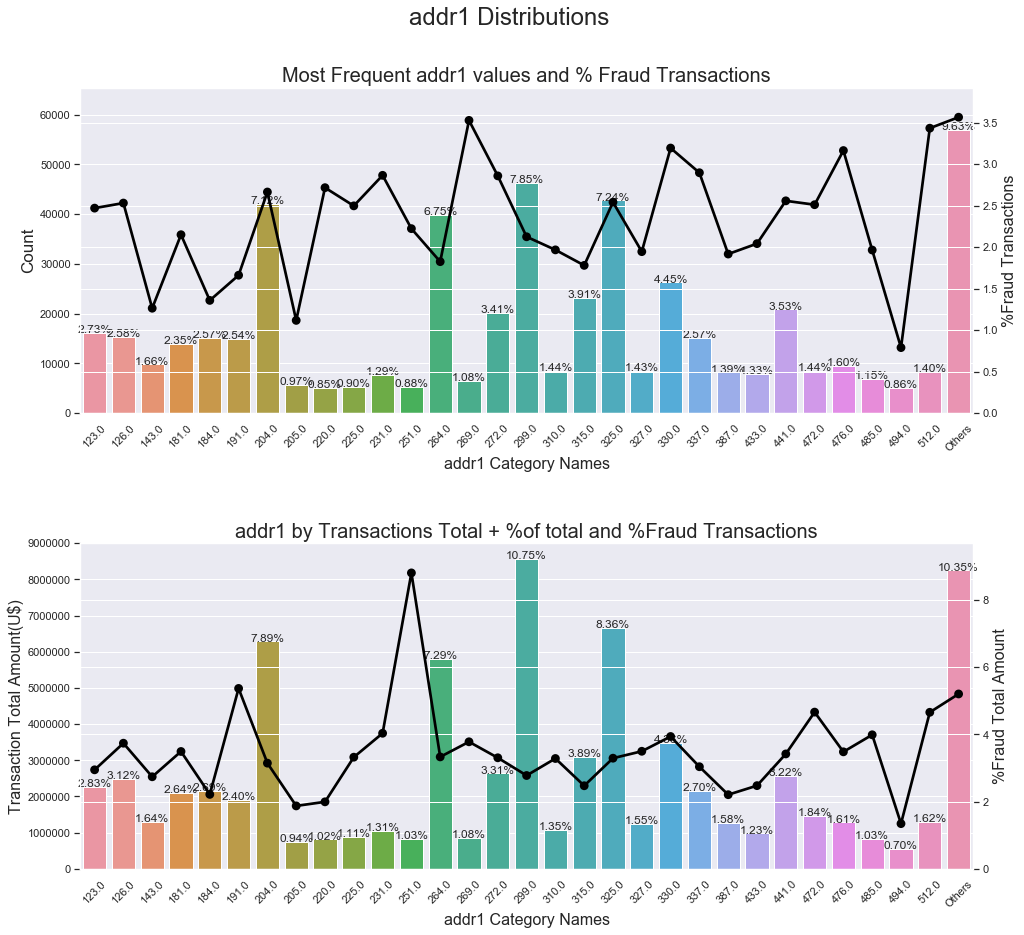

In [17]:
def ploting_cnt_amt(DataFile, Column, lim=2000):
    tmp = pd.crosstab(DataFile[Column], DataFile['isFraud'], normalize='index') * 100
    tmp = tmp.reset_index()
    tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)
    
    plt.figure(figsize=(16,14))    
    plt.suptitle(f'{Column} Distributions ', fontsize=24)
    
    plt.subplot(211)
    plot_1 = sns.countplot(x=Column,data=DataFile,order=list(tmp[Column].values))
    plot_1_2 = plot_1.twinx()
    plot_1_2 = sns.pointplot(x=Column, y='Fraud', data=tmp, order=list(tmp[Column].values),
                       color='black', legend=False)
    plot_1_2.set_ylim(0,tmp['Fraud'].max()*1.1)
    plot_1_2.set_ylabel("%Fraud Transactions", fontsize=16)
    plot_1.set_title(f"Most Frequent {Column} values and % Fraud Transactions", fontsize=20)
    plot_1.set_xlabel(f"{Column} Category Names", fontsize=16)
    plot_1.set_ylabel("Count", fontsize=17)
    plot_1.set_xticklabels(plot_1.get_xticklabels(),rotation=45)
    sizes = []
    for p in plot_1.patches:
        height = p.get_height()
        sizes.append(height)
        plot_1.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(height/total*100),
                ha="center",fontsize=12) 
        
    plot_1.set_ylim(0,max(sizes)*1.15)
    
   



    perc_amt = (DataFile.groupby(['isFraud',Column])['TransactionAmt'].sum() \
                / DataFile.groupby([Column])['TransactionAmt'].sum() * 100).unstack('isFraud')
    perc_amt = perc_amt.reset_index()
    perc_amt.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)
    amt = DataFile.groupby([Column])['TransactionAmt'].sum().reset_index()
    perc_amt = perc_amt.fillna(0)
    plt.subplot(212)
    plot_2 = sns.barplot(x=Column, y='TransactionAmt', 
                       data=amt, 
                       order=list(tmp[Column].values))
    plot_2_2 = plot_2.twinx()
    plot_2_2 = sns.pointplot(x=Column, y='Fraud', data=perc_amt, 
                        order=list(tmp[Column].values),
                       color='black', legend=False, )
    plot_2_2.set_ylim(0,perc_amt['Fraud'].max()*1.1)
    plot_2_2.set_ylabel("%Fraud Total Amount", fontsize=16)
    plot_2.set_xticklabels(plot_2.get_xticklabels(),rotation=45)
    plot_2.set_title(f"{Column} by Transactions Total + %of total and %Fraud Transactions", fontsize=20)
    plot_2.set_xlabel(f"{Column} Category Names", fontsize=16)
    plot_2.set_ylabel("Transaction Total Amount(U$)", fontsize=16)
    plot_2.set_xticklabels(plot_2.get_xticklabels(),rotation=45)    
    
    for p in plot_2.patches:
        height = p.get_height()
        plot_2.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(height/total_amt*100),
                ha="center",fontsize=12) 
        
    plt.subplots_adjust(hspace=.4, top = 0.9)
    plt.show()
    
ploting_cnt_amt(train_transaction, 'addr1')

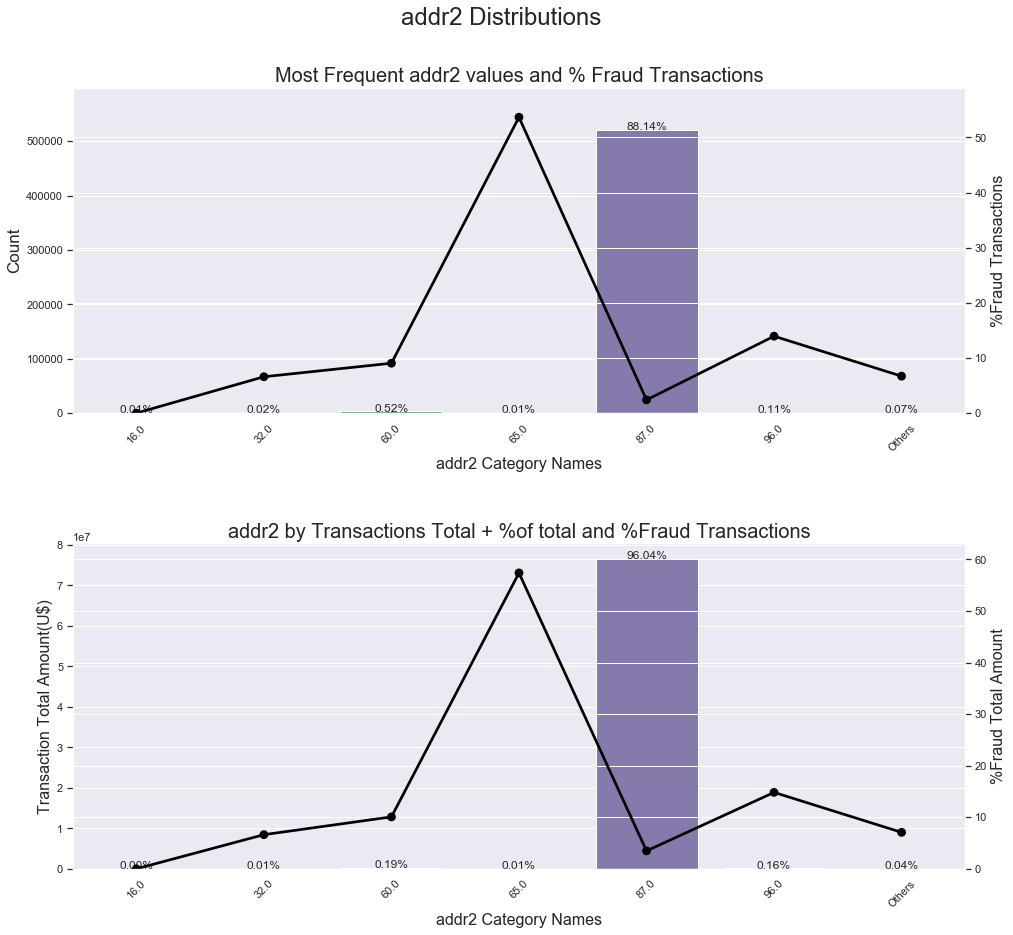

In [18]:
ploting_cnt_amt(train_transaction, 'addr2')

###  Ploting P-Email Domain

In [19]:
train_transaction.loc[train_transaction['P_emaildomain'].isin(['gmail.com', 'gmail']),'P_emaildomain'] = 'Google'

train_transaction.loc[train_transaction['P_emaildomain'].isin(['yahoo.com', 'yahoo.com.mx',  'yahoo.co.uk',
                                         'yahoo.co.jp', 'yahoo.de', 'yahoo.fr',
                                         'yahoo.es']), 'P_emaildomain'] = 'Yahoo Mail'
train_transaction.loc[train_transaction['P_emaildomain'].isin(['hotmail.com','outlook.com','msn.com', 'live.com.mx', 
                                         'hotmail.es','hotmail.co.uk', 'hotmail.de',
                                         'outlook.es', 'live.com', 'live.fr',
                                         'hotmail.fr']), 'P_emaildomain'] = 'Microsoft'
train_transaction.loc[train_transaction.P_emaildomain.isin(train_transaction.P_emaildomain\
                                         .value_counts()[train_transaction.P_emaildomain.value_counts() <= 500 ]\
                                         .index), 'P_emaildomain'] = "Others"
train_transaction.P_emaildomain.fillna("NoInf", inplace=True)

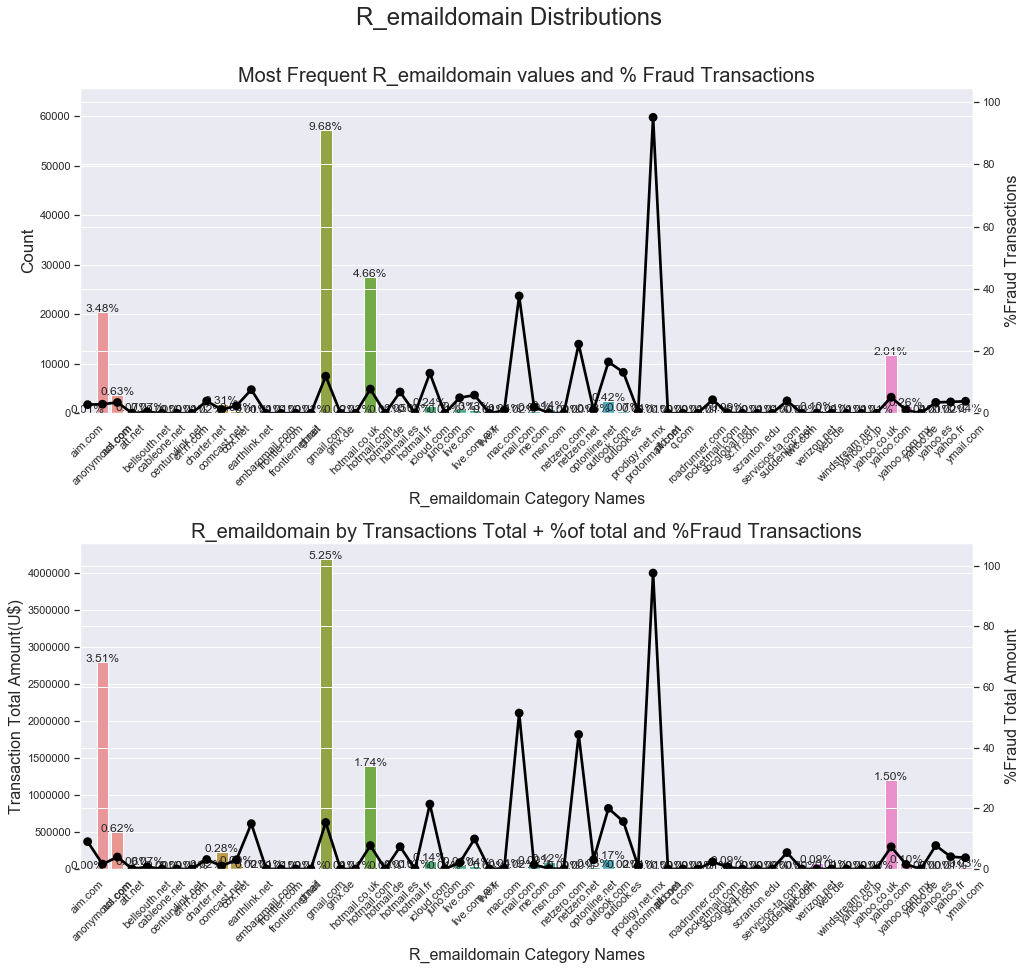

In [20]:
ploting_cnt_amt(train_transaction, 'R_emaildomain')

### Exploring C1-C14 features

In [21]:
train_transaction.loc[train_transaction.C1.isin(train_transaction.C1\
                              .value_counts()[train_transaction.C1.value_counts() <= 400 ]\
                              .index), 'C1'] = "Others"

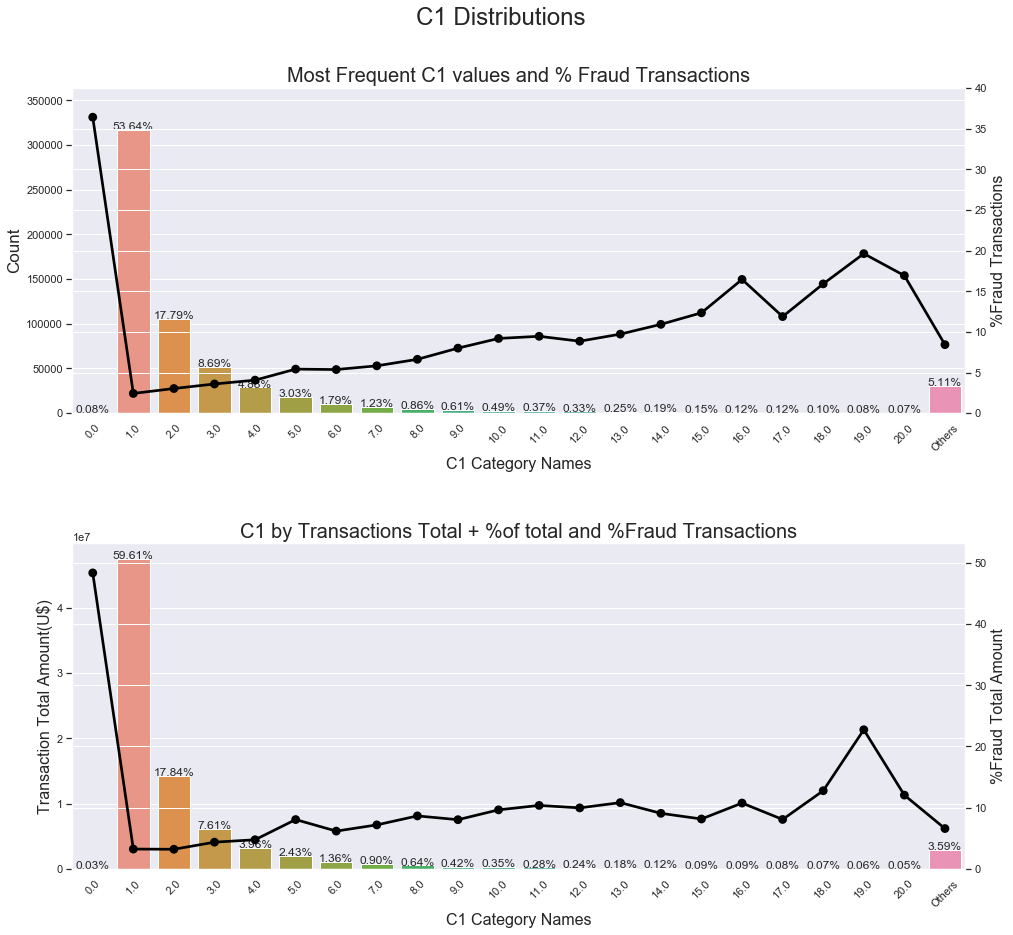

In [22]:
ploting_cnt_amt(train_transaction, 'C1')

### TimeDelta Feature to check if frauds have some specific hour that has highest % of frauds

In [24]:
import datetime

START_DATE = '2017-12-01'
startdate = datetime.datetime.strptime(START_DATE, "%Y-%m-%d")
train_transaction["Date"] = train_transaction['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds=x)))
train_transaction['_Weekdays'] = train_transaction['Date'].dt.dayofweek
train_transaction['_Hours'] = train_transaction['Date'].dt.hour
train_transaction['_Days'] = train_transaction['Date'].dt.day

test_transaction["Date"] = test_transaction['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds=x)))
test_transaction['_Weekdays'] = test_transaction['Date'].dt.dayofweek
test_transaction['_Hours'] = test_transaction['Date'].dt.hour
test_transaction['_Days'] = test_transaction['Date'].dt.day

### Top Days with highest Total Transaction Amount

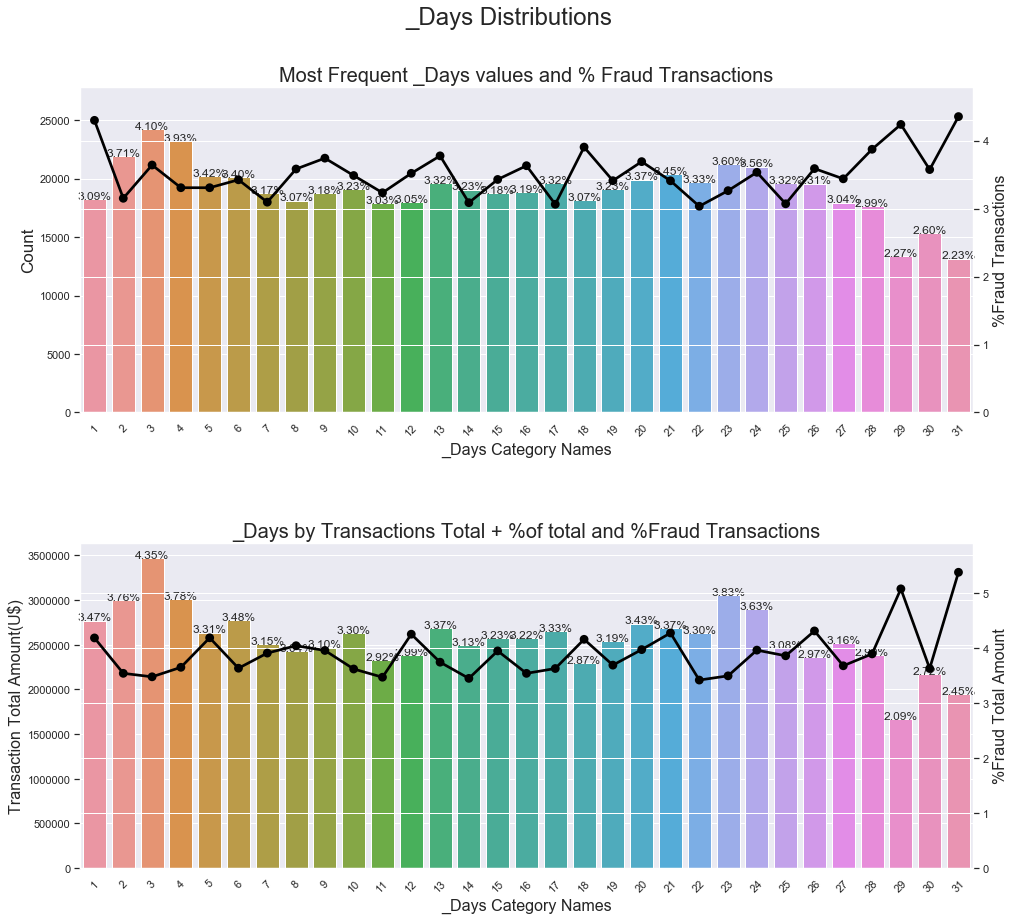

In [26]:
ploting_cnt_amt(train_transaction, '_Days')


### Ploting WeekDays Distributions


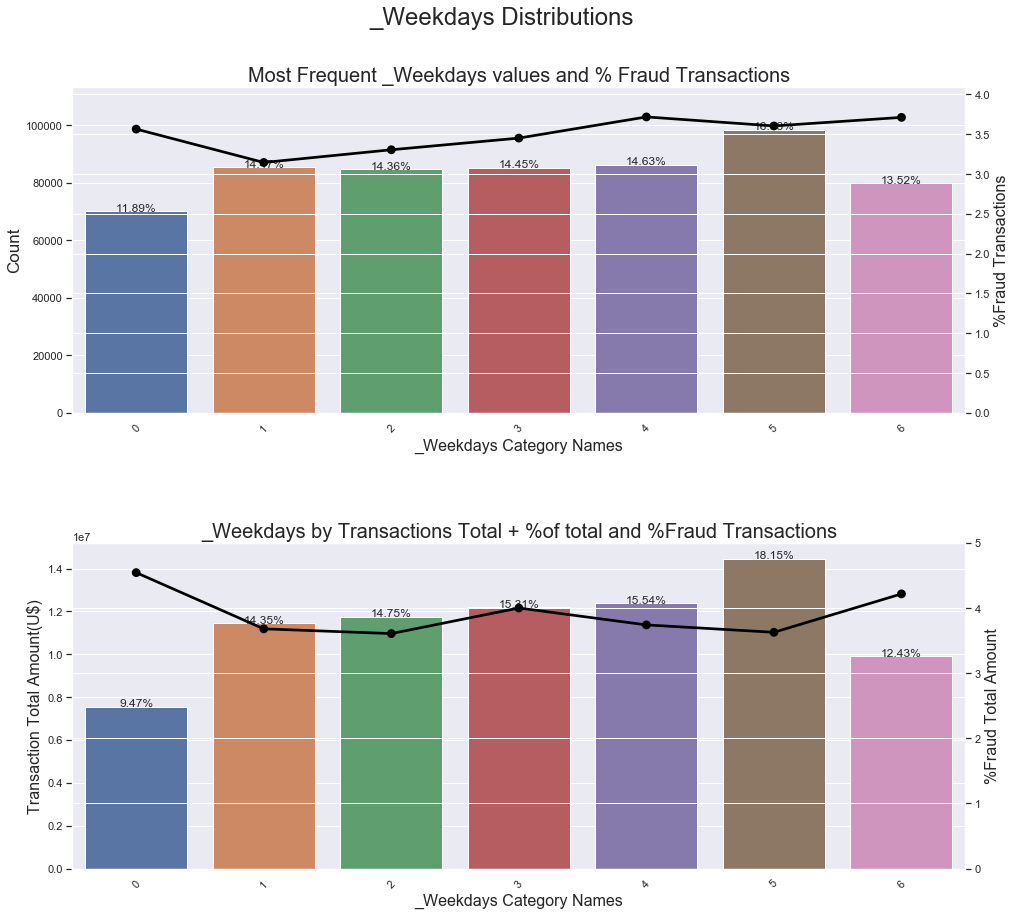

In [27]:
ploting_cnt_amt(train_transaction, '_Weekdays')


### Ploting Hours Distributions

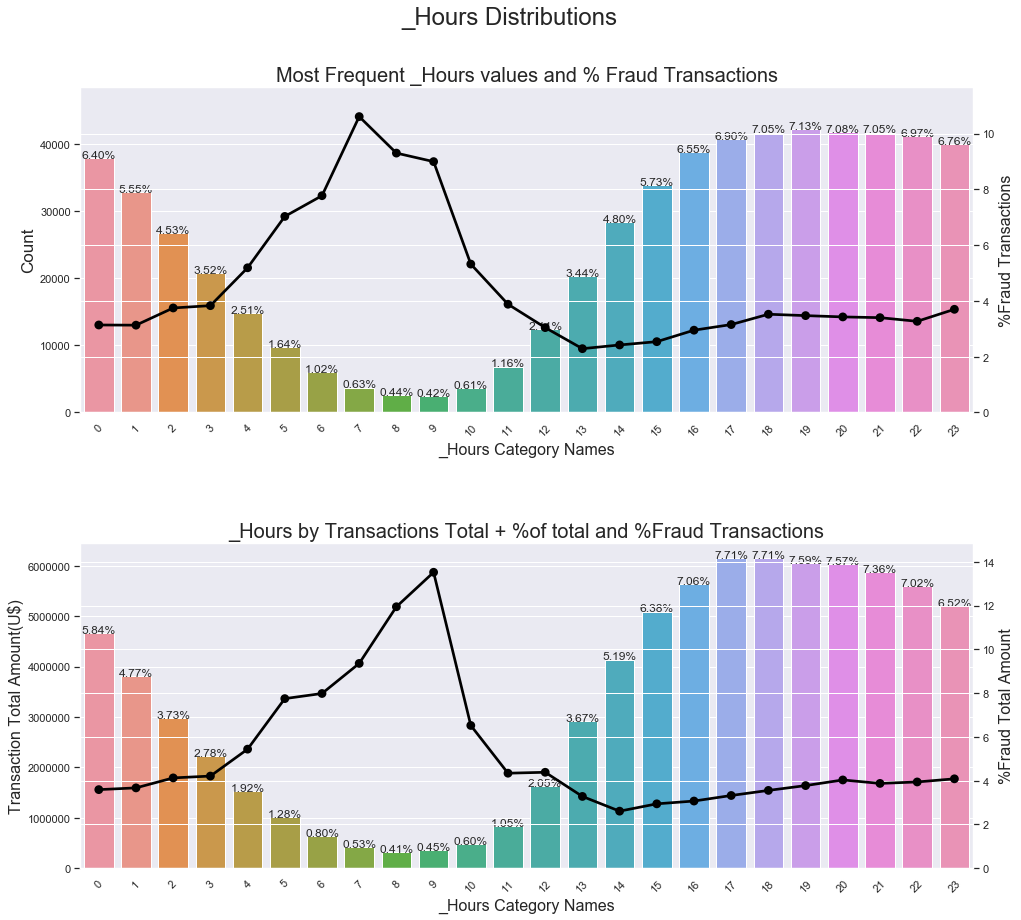

In [28]:
ploting_cnt_amt(train_transaction, '_Hours')
